In [9]:
# For data 
import pandas as pd
# For datetime manipulation.
import datetime as dt
from datetime import time
import time
# For regression.
import numpy as np
import random
# For numerical analysis
from scipy.stats import norm
from scipy.optimize import brentq
# For plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from scipy.interpolate import griddata # For smoothening
# For random sampling
import random


In [11]:
# 1 file analysis --> 
LOGFILE='Saved Computations for Options Expiry 14-Aug-2025.csv'
data=pd.read_csv(LOGFILE,index_col=False);
data["timestamp"]=pd.to_datetime(data["timestamp"])
data["expiry"]=pd.to_datetime(data["expiry"]);
data["strike"]=(data["strike"]).astype(float)

In [4]:
old_data=data.copy();

In [17]:
# Doing for volatility Smile. 
# ---- Style ----
wanted_choices = ["Slightly ITM", "ATM", "Slightly OTM"]
used_color = ["orange", "green", "blue"]
color_map_for_graph = dict(zip(wanted_choices, used_color))
# Filter relevant rows
data["date_only"]=data["timestamp"].dt.date
selected_date=dt.date(2025,8,8) # No particular reason, just a random date
data=data[data["date_only"]==selected_date] 
data = data[data["classification"].isin(wanted_choices)]
SET=list(set(data["timestamp"]));
SET=sorted(SET);

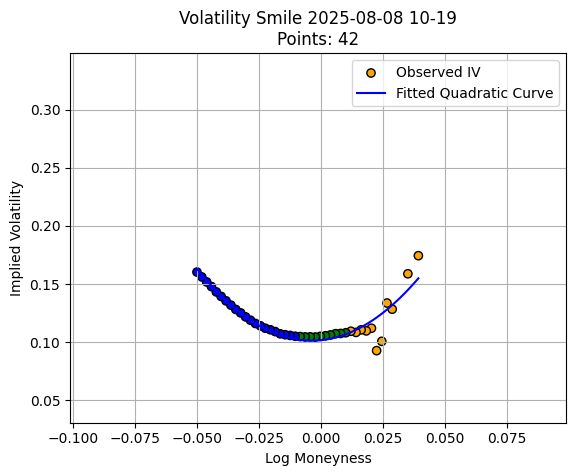

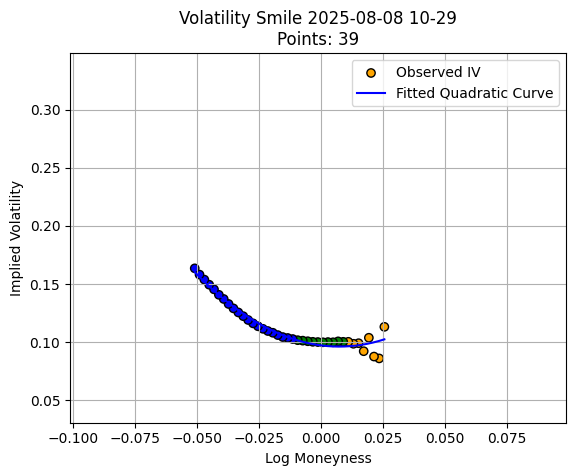

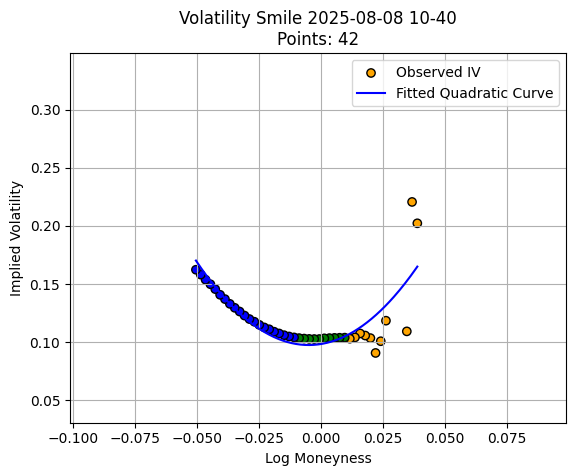

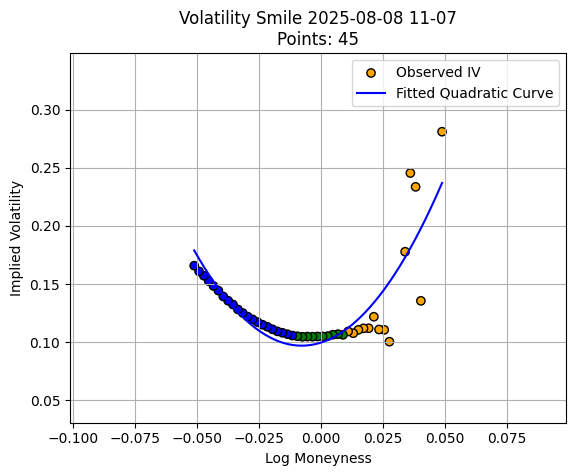

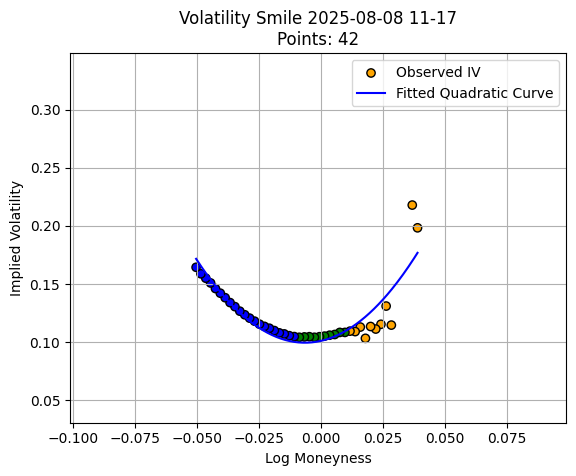

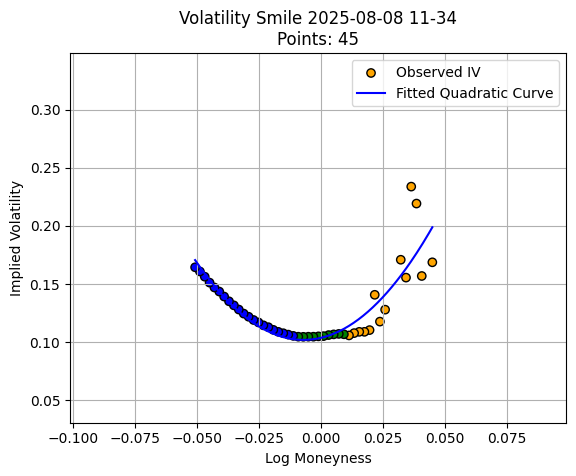

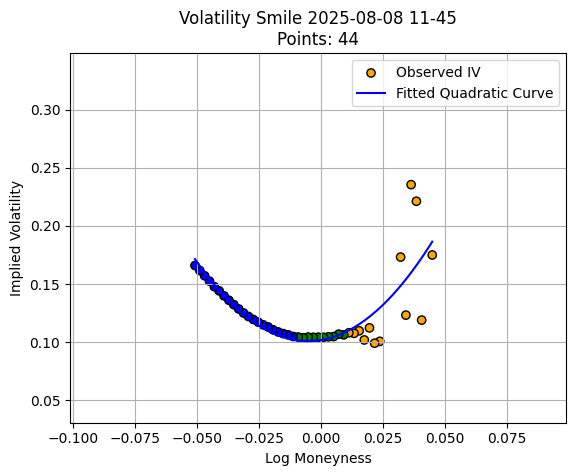

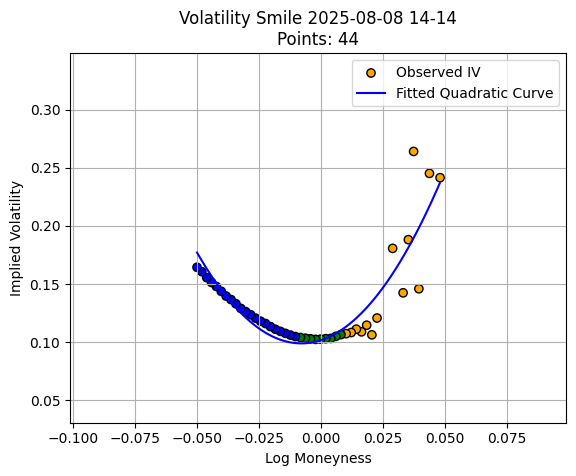

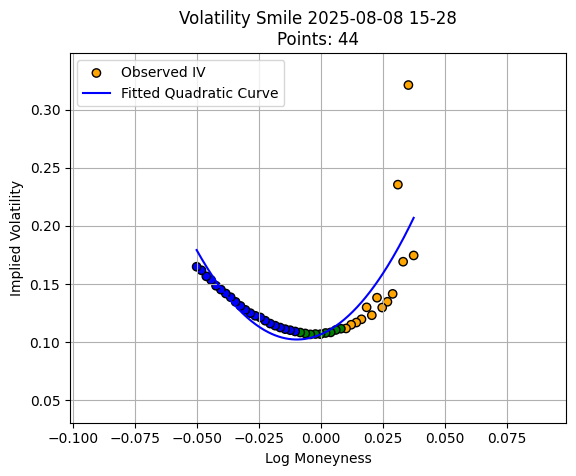

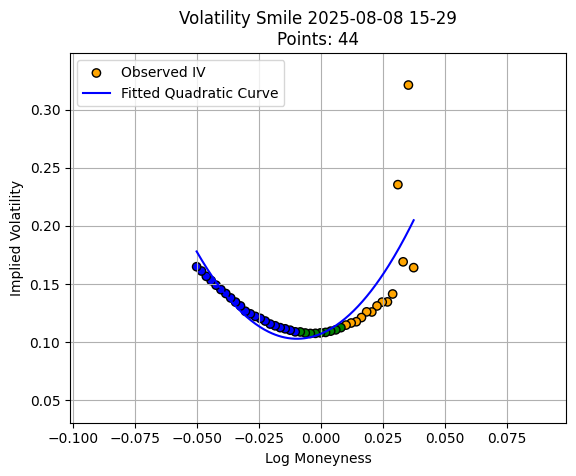

In [19]:
# For volaility Smile - 10 random data from set
x_min, x_max = data["Log_moneyness"].min(), data["Log_moneyness"].max()
y_min, y_max = data["Implied Volatility NR"].min(), data["Implied Volatility NR"].max()
Random_Sampling =random.sample(SET, 10)
Random_Sampling=sorted(Random_Sampling);
for t in Random_Sampling:
    newdata = data[data["timestamp"]== t][
        ["Log_moneyness", "Implied Volatility NR", "classification"]
    ].dropna()
    if len(newdata) > 5:
        # Extract variables
        X = newdata["Log_moneyness"].values
        y = newdata["Implied Volatility NR"].values
        colors = newdata["classification"].map(color_map_for_graph).values  

        # Scatter plot
        plt.scatter(X, y, c=colors, edgecolor="black", label="Observed IV")

        # Fit quadratic regression
        X_design = np.column_stack((np.ones_like(X), X, X**2))
        beta, *_ = np.linalg.lstsq(X_design, y, rcond=None)

        # Smooth curve
        X_smooth = np.linspace(X.min(), X.max(), 200)
        X_smooth_design = np.column_stack((np.ones_like(X_smooth), X_smooth, X_smooth**2))
        Y_smooth_pred = X_smooth_design @ beta

        plt.plot(X_smooth, Y_smooth_pred, 'b-', label="Fitted Quadratic Curve")
        TITLE="Volatility Smile " +str(selected_date) + " "+ t.strftime('%H-%M')

        plt.title(TITLE+"\n"
                  f"Points: {len(newdata)}")
        plt.xlabel("Log Moneyness")
        plt.ylabel("Implied Volatility")
        plt.xlim(x_min - 0.05, x_max + 0.05)
        plt.ylim(y_min - 0.02, y_max + 0.02)
        plt.grid(True)
        plt.legend()
        TITLE=TITLE+".jpg"
        plt.savefig(TITLE, format="jpg", dpi=300)  # 300 DPI = good quality
        plt.show()
        

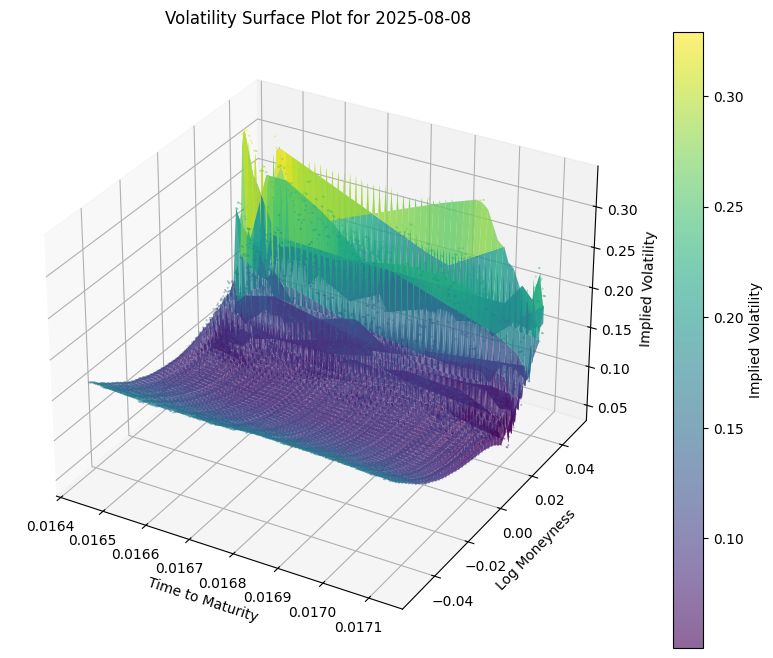

In [13]:
data = data.dropna(subset=["time_to_maturity", "Log_moneyness", "Implied Volatility NR"])

# Create grid for smooth surface
xi = np.linspace(data["time_to_maturity"].min(), data["time_to_maturity"].max(), 400)
yi = np.linspace(data["Log_moneyness"].min(), data["Log_moneyness"].max(), 400)
xi, yi = np.meshgrid(xi, yi)

# Interpolation methods available(linear, cubic, nearest)
zi = griddata((data["time_to_maturity"],data["Log_moneyness"]), data["Implied Volatility NR"], (xi, yi), method='linear')


# Create 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(xi, yi, zi, cmap='viridis', alpha=0.8)

sc = ax.scatter(
    data["time_to_maturity"], 
    data["Log_moneyness"], 
    data["Implied Volatility NR"], 
    c=data["Implied Volatility NR"],  # color by implied vol
    cmap='viridis',
    s=.1,  # point size
    alpha=0.6
)

ax.set_xlabel("Time to Maturity")
ax.set_ylabel("Log Moneyness")
ax.set_zlabel("Implied Volatility")
TITLE="Volatility Surface Plot for " +str(selected_date)
ax.set_title(TITLE)

fig.colorbar(sc, ax=ax, label="Implied Volatility")
plt.savefig(TITLE+".jpg", format="jpg", dpi=300)  

plt.show()
